In [1]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
print(pm.__version__)
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm

%matplotlib inline
plt.style.use('bmh')
#plt.rc('text', usetex=True)

3.0.rc4


# Data

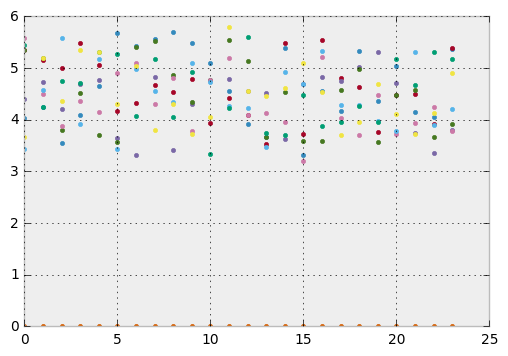

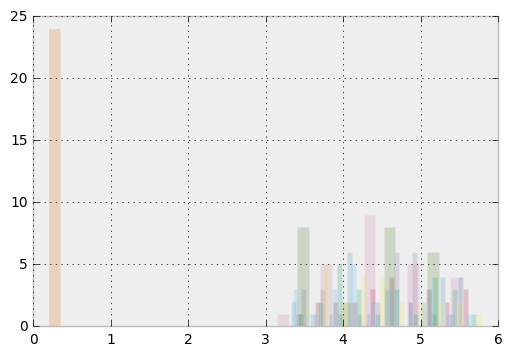

In [2]:
x = np.arange(24)
n = 3
y_mean = .5
y_std = 2
y_scale = y_mean**2/y_std
y_shape = y_std/y_mean
y = np.random.gamma(scale=y_scale, shape=y_shape, size=(len(x),n,n)) + 3 
y = y + np.array([np.random.random(size=(n,n))*2 for i in range(len(x))])
y[:,1,1] = np.zeros(len(x))
for i in range(n):
    plt.plot(x, y[:,:,i], '.')
plt.figure()
bins = 10
for i in range(n):
    _ = plt.hist(y[:,:,i], bins=bins, alpha=.2)

# Model

In [3]:
last=False
def timing(reset=False):
    from datetime import datetime
    global last
    global startt
    if reset or not last:
        last = datetime.now()
        startt = datetime.now()
    else:
        duration = datetime.now() - last
        print('last:',duration.total_seconds(),'s')
        print('total:',(datetime.now() - startt).total_seconds(),'s')
        last = datetime.now()

In [4]:
# using old data and simpler model
def update_model(alpha_mean, alpha_std, beta_mean, beta_std, y):
    with pm.Model() as model:
        timing(True)
        alpha = pm.Normal('alpha', mu=alpha_mean, sd=alpha_std, shape=(n,n))
        print("defined alpha vars")
        timing()

        beta = pm.Normal('beta', mu=beta_mean, sd=beta_std, shape=(n,n))
        print("defined beta vars")
        timing()

        Y = pm.Normal('Y', mu=alpha, sd=beta, observed=y)
        print("defined Y")
        timing()

        start = pm.find_MAP()    
        print("found start")
        timing()

        step = pm.NUTS()
        print("set NUTS")
        timing()

        trace = pm.sample(500, step, start=start, progressbar=True)
        timing()
        
        return trace
        
trace = update_model(np.ones([n,n])*2, 
             np.ones([n,n])*3, 
             np.ones([n,n])*.1, 
             np.ones([n,n]),
             y)

defined alpha vars
last: 6.052517 s
total: 6.05296 s
defined beta vars
last: 0.014412 s
total: 6.068055 s
defined Y
last: 0.104145 s
total: 6.172872 s


/usr/lib/python3.5/site-packages/pymc3/distributions/continuous.py:60: UserWarning: The variable specified for sd has negative support for Normal, likely making it unsuitable for this parameter.
  warnings.warn(msg)


         Current function value: 199.393245
         Iterations: 53
         Function evaluations: 145
         Gradient evaluations: 132
found start
last: 2.825115 s
total: 8.999133 s


  2%|▏         | 8/500 [00:00<00:06, 72.51it/s]

set NUTS
last: 5.736994 s
total: 14.7371 s


100%|██████████| 500/500 [00:03<00:00, 163.44it/s]

last: 3.062854 s
total: 17.800823 s



alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  ..............................[0, :]...............................
  4.708            0.001            0.000            [4.708, 4.708]
  4.204            0.002            0.000            [4.204, 4.204]
  4.615            0.001            0.000            [4.615, 4.615]
  ..............................[1, :]...............................
  4.636            0.001            0.000            [4.636, 4.636]
  -0.000           0.004            0.000            [-0.000, 0.000]
  4.040            0.001            0.000            [4.040, 4.040]
  ..............................[2, :]...............................
  4.645            0.002            0.000            [4.645, 4.645]
  4.404            0.002            0.000            [4.404, 4.404]
  4.524            0.001            0.000            [4.524, 4.524]

  Posterior quantiles:
  2.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7facec5484e0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7faccd188e80>]], dtype=object)

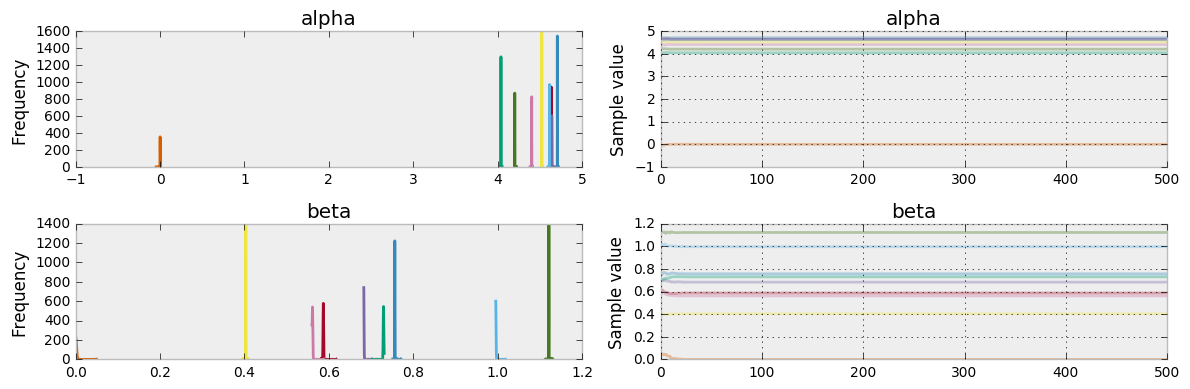

In [5]:
pm_params = {'trace': trace,
             'varnames': ['alpha', 'beta']}

pm.summary(**pm_params)
pm.traceplot(**pm_params)

*As seen in the straight lines above, MCMC has problems with 0 values and does not walk probperly.*